In [20]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay,auc,classification_report,roc_auc_score,roc_curve,precision_recall_curve
from sklearn.preprocessing import label_binarize


In [3]:
#loading the transformed Data Set
solar_data = pd.read_csv(r"solar_data_transformed18.csv")
print(solar_data.columns)

Index(['ID', 'County', 'InstallType', 'UrbanRural', 'Class', 'Percent_100',
       'Substation_100', 'HIFLD_100', 'Percent_200', 'Substation_200',
       'HIFLD_200', 'Percent_CAISO', 'Substation_CAISO', 'HIFLD_CAISO',
       'SolarTech', 'Area', 'Length', 'DistSub_100_binned',
       'DistSub_200_binned', 'DistSub_CAISO_binned'],
      dtype='object')


In [4]:
X_scaled = solar_data.drop(columns=['ID','InstallType'])  # Features
y = solar_data['InstallType']  # Target

In [5]:
#Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

In [6]:
#Split the PCA-transformed data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [7]:
#Train and tune KNN on PCA data
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 10], 'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 10],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

Best Parameters: {'n_neighbors': 7, 'weights': 'distance'}
Accuracy: 0.8583333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90       427
           1       0.83      0.79      0.81       287
           2       0.80      0.90      0.85       366

    accuracy                           0.86      1080
   macro avg       0.86      0.85      0.85      1080
weighted avg       0.86      0.86      0.86      1080

ROC-AUC Score: 0.9576442218370987


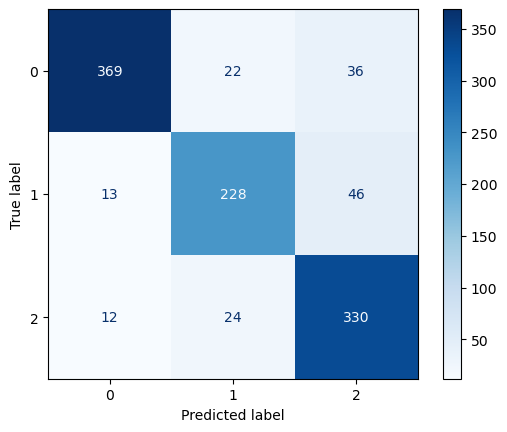

In [21]:
# Evaluate the best model
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Classification Report:\n", classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')

y_prob = best_knn.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)


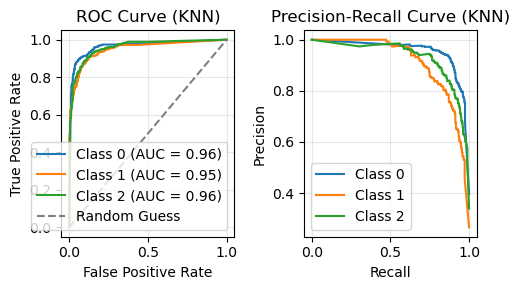

In [27]:
# Binarize the test labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))  # Use y_train for consistent class labels
y_prob = best_knn.predict_proba(X_test)  # Predicted probabilities

# Plot ROC Curve
plt.figure(figsize=(5, 3))

# ROC Curve for each class
n_classes = len(np.unique(y_train))  # Number of classes
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.title("ROC Curve (KNN)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# Precision-Recall Curve
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"Class {i}")

plt.subplot(1, 2, 2)
plt.title("Precision-Recall Curve (KNN)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### KKN with PCA Insights

The model boasted an accuracy of 86%, but more impressively, it attained a very high ROC-AUC score of 0.9576, reflecting great performance in terms of class separation. Class 0 performed quite well, having a precision of 0.94, a recall of 0.86, and an F1-score of 0.90, though with some room for improvement in the area of recall. 
Class 2 also performed very well with a recall of 0.90 and an F1-score of 0.85, though the precision was a bit lower at 0.80, indicating some false positives. Class 1 was relatively weaker in performance, with a precision of 0.83, recall of 0.79, and F1-score of 0.81, which indicates that further optimization might be required for this model, such as dealing with class imbalance or tweaking decision thresholds. PCA helped reduce the dimensions and allowed for greater focus on key features; however, there is scope for further fine-tuning. 
The macro average F1 of 0.85 and weighted average F1 of 0.86 indicate a balanced performance, although a further tuning for class 1 would have great value.